Импортируем библиотеки

In [1]:
import random
import numpy as np
import pandas as pd
import math
import os
import matplotlib.pyplot as plt
import seaborn as sns
from kaggle_environments import make, evaluate

No pygame installed, ignoring import
Loading environment lux_ai_s3 failed: No module named 'chex'


Создадим простейшие агенты:

In [2]:
%%writefile rock.py


# 0 - rock
# 1 - paper
# 2 - scissors
def rock(observation, configuration):
    return 0

Overwriting rock.py


In [3]:
%%writefile paper.py

# всегда возвращаем бумагу
def paper(observation, configuration):
    return 1

Overwriting paper.py


In [4]:
%%writefile scissors.py

# всегда возвращаем ножницы
def scissors(observation, configuration):
    return 2

Overwriting scissors.py


In [32]:
evaluate(
    "rps", # служебный параметр
    ["rock.py", "paper.py"], # наши игроки
    configuration={"episodeSteps": 100} # количество игр
)

[[-99.0, 99.0]]

In [1]:
%%writefile step_by_step.py

def sequential_agent(observation, configuration):
    return (observation.step % configuration.signs)

Writing step_by_step.py


Теперь реализуем следующую логику: 

- если предыдущее действие выиграло, то мы повторяем его

- если действие привело к проигрышу, создадим новое случайное действие

In [7]:
%%writefile save_wins.py

import random 

action_history = []

def save_wins(observation, configuration):
    global action_history

    def determine_result(my_move, opponent_move):
        if my_move == opponent_move:
            return 0  # Ничья
        elif (my_move - opponent_move) % configuration.signs == 1:
            return 1  # Победа
        else:
            return -1  # Поражение

    if observation.step == 0:
        next_action = random.randrange(configuration.signs)
    else:
        last_result = determine_result(action_history[-1], observation.lastOpponentAction)
        if last_result == 1:
            next_action = action_history[-1]  # Повторяем предыдущий успешный ход
        else:
            next_action = random.randrange(configuration.signs)  # Выбираем случайный ход
    action_history.append(next_action)
    return next_action

Overwriting save_wins.py


In [8]:
%%writefile true_random.py

import random 

def true_random(observation, configuration):
    return random.randint(0, 2)

Overwriting true_random.py


In [9]:
# 500 раз запустим игру
env = make("rps",configuration={"episodeSteps": 500}, debug=True)

# Запускаем игру save_wins против настоящего рандома 
env.run(['save_wins.py', 'true_random.py'])

# Отображаем результаты игры
env.render(mode="ipython", width=500, height=500)
print(env)

`save wins` справляется куда лучше рандома! 

Пусть другой агент анализирует частоту решений противника и выбирает наиболее часто побеждающий

In [10]:
%%writefile enemy_analytics.py

from collections import Counter
import random 

opponent_moves = []

def enemy_analytics(observation, configuration):
    global opponent_moves
    if observation.step == 0:
        opponent_moves = []
        return random.randrange(configuration.signs)
    
    opponent_moves.append(observation.lastOpponentAction)
    move_counts = Counter(opponent_moves)
    most_common_move = move_counts.most_common(1)[0][0]
    return (most_common_move + 1) % configuration.signs

Overwriting enemy_analytics.py


In [11]:
# 1000 раз запустим игру
env = make("rps",configuration={"episodeSteps": 1000}, debug=True)

# Запускаем игру save_wins против настоящего рандома 
env.run(['save_wins.py', 'enemy_analytics.py'])

# Отображаем результаты игры
env.render(mode="ipython", width=500, height=500)
print(env)

`save_wins` снова побеждает!

Проверим, сможет ли прогнозист победить чемпиона

In [12]:
%%writefile predictor.py

import random

pattern_history = {}

def predictor(observation, configuration):
    global pattern_history
    if observation.step == 0:
        pattern_history = {}
        return random.randrange(configuration.signs)
    
    last_move = observation.lastOpponentAction
    if last_move in pattern_history:
        pattern_history[last_move] += 1
    else:
        pattern_history[last_move] = 1

    # Предсказываем следующий ход противника
    predicted_move = max(pattern_history, key=pattern_history.get)
    return (predicted_move + 1) % configuration.signs

Overwriting predictor.py


In [13]:
# 1000 раз запустим игру
env = make("rps",configuration={"episodeSteps": 1000}, debug=True)

# Запускаем игру save_wins против настоящего рандома 
env.run(['predictor.py', 'save_wins.py'])

# Отображаем результаты игры
env.render(mode="ipython", width=500, height=500)
print(env)

Поразительно, `save_wins` снова победил

Добавим ещё несколько простеньких агентов, чтобы общая таблица была интереснее:

In [2]:
%%writefile altersteps.py

def alter_agent(observation, configuration):
    return observation.step % 2

Writing altersteps.py


In [17]:
%%writefile doubler.py

import random 

def doubler(observation, configuration):
    print(f"Step: {observation.step}, Signs: {configuration.signs}")  # Для проверки
    if observation.step == 0:
        return random.randrange(configuration.signs)
    return (observation.step * 2) % configuration.signs

Overwriting doubler.py


In [20]:
%%writefile limitedcycler.py

def limited_cycler(observation, configuration):
    return (observation.step * 2) % configuration.signs

Writing limitedcycler.py


In [4]:
%%writefile anticycle

def counter_cycler_agent(observation, configuration):
    return (observation.step + 1) % configuration.signs


Writing anticycle


In [8]:
%%writefile mirror_blocker.py

import random 

def mirror_blocker(observation, configuration):
    print(f"Step: {observation.step}, Signs: {configuration.signs}")  # Для проверки
    if observation.step == 0:
        return random.randrange(0,3)
    return (observation.lastOpponentAction + 1) % configuration.signs

Overwriting mirror_blocker.py


In [9]:
env = make("rps", debug=True)
env.run(['mirror_blocker.py', "scissors.py"])
env.render(mode="ipython")

Step: 0, Signs: 3
Step: 1, Signs: 3
Step: 2, Signs: 3
Step: 3, Signs: 3
Step: 4, Signs: 3
Step: 5, Signs: 3
Step: 6, Signs: 3
Step: 7, Signs: 3
Step: 8, Signs: 3
Step: 9, Signs: 3
Step: 10, Signs: 3
Step: 11, Signs: 3
Step: 12, Signs: 3
Step: 13, Signs: 3
Step: 14, Signs: 3
Step: 15, Signs: 3
Step: 16, Signs: 3
Step: 17, Signs: 3
Step: 18, Signs: 3
Step: 19, Signs: 3
Step: 20, Signs: 3
Step: 21, Signs: 3
Step: 22, Signs: 3
Step: 23, Signs: 3
Step: 24, Signs: 3
Step: 25, Signs: 3
Step: 26, Signs: 3
Step: 27, Signs: 3
Step: 28, Signs: 3
Step: 29, Signs: 3
Step: 30, Signs: 3
Step: 31, Signs: 3
Step: 32, Signs: 3
Step: 33, Signs: 3
Step: 34, Signs: 3
Step: 35, Signs: 3
Step: 36, Signs: 3
Step: 37, Signs: 3
Step: 38, Signs: 3
Step: 39, Signs: 3
Step: 40, Signs: 3
Step: 41, Signs: 3
Step: 42, Signs: 3
Step: 43, Signs: 3
Step: 44, Signs: 3
Step: 45, Signs: 3
Step: 46, Signs: 3
Step: 47, Signs: 3
Step: 48, Signs: 3
Step: 49, Signs: 3
Step: 50, Signs: 3
Step: 51, Signs: 3
Step: 52, Signs: 3
Ste

Наконец, проверим нейронку против нашего победителя

In [14]:
%%writefile neuroagent.py

import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense


history = []

# Наша моделька
def create_model():
    model = Sequential([
        Dense(16, activation='relu', input_shape=(6,)),  # вход 6 данных, скрытый слой 16 нейронов
        Dense(16, activation='relu'),                    # допслой
        Dense(3, activation='softmax')                   # на выходе вероятность для каждого хода
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model

model = create_model()

def neuroagent(observation, configuration):
    global history, model

    # Добавляем предыдущий ход соперника и наш ход в историю
    if observation.step > 0:
        history.append(observation.lastOpponentAction)
        history.append(history[-2])

    # Если данных недостаточно, выбираем случайный ход
    if len(history) < 6:
        action = int(np.random.randint(configuration.signs))
        history.append(action)
        return action

    # Формируем входные данные из последних 6 ходов
    input_data = np.array(history[-6:]).reshape(1, -1)

    # Прогнозируем следующий ход соперника
    opponent_pred = np.argmax(model.predict(input_data, verbose=0)[0])

    # Выбираем действие, которое побеждает предсказанный ход соперника
    action = (opponent_pred + 1) % configuration.signs
    history.append(action)

    # Обучение модели
    if observation.step > 0:
        target = np.zeros(configuration.signs)
        target[observation.lastOpponentAction] = 1
        model.fit(input_data, target.reshape(1, -1), epochs=1, verbose=0)

    return int(action)

Overwriting neuroagent.py


In [15]:
# 1000 раз запустим игру
env = make("rps",configuration={"episodeSteps": 1000}, debug=True)

# Запускаем игру save_wins против настоящего рандома 
env.run(['neuroagent.py', 'save_wins.py'])

# Отображаем результаты игры
env.render(mode="ipython", width=500, height=500)
print(env)

C:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Поразительно, но `save_wins` выигрывает и простую нейронную сеть! Но уже не с таким разрядом)

В беседе группы ребята посоветовали мне `decision_tree`. Что ж , воспользуемся им

In [16]:
%%writefile decision_tree.py

import numpy as np
import collections
from sklearn.tree import DecisionTreeClassifier

def construct_local_features(rollouts):
    step_mode_features = np.array([[step % k for step in rollouts['steps']] for k in (2, 3, 5)])
    step_div_features = np.array([[step // k for step in rollouts['steps']] for k in (100, 150, 250)])
    features = np.concatenate([step_mode_features, step_div_features])
    features = np.append(features, rollouts['actions'])
    features = np.append(features, rollouts['opp-actions'])
    return features

def construct_global_features(rollouts):
    features = []
    for key in ['actions', 'opp-actions']:
        for i in range(3):
            actions_count = np.mean([r == i for r in rollouts[key]])
            features.append(actions_count)
    return np.array(features)

def construct_features(short_stat_rollouts, long_stat_rollouts):
    lf = construct_local_features(short_stat_rollouts)
    gf = construct_global_features(long_stat_rollouts)
    features = np.concatenate([lf, gf])
    return features

def predict_opponent_move(train_data, test_sample):
    classifier = DecisionTreeClassifier(random_state=42)
    classifier.fit(train_data['x'], train_data['y'])
    return classifier.predict(test_sample)

def update_rollouts_hist(rollouts_hist, last_move, opp_last_action):
    rollouts_hist['steps'].append(last_move['step'])
    rollouts_hist['actions'].append(last_move['action'])
    rollouts_hist['opp-actions'].append(opp_last_action)
    return rollouts_hist

def warmup_strategy(observation, configuration):
    global rollouts_hist, last_move
    action = int(np.random.randint(3))
    if observation.step == 0:
        last_move = {'step': 0, 'action': action}
        rollouts_hist = {'steps': [], 'actions': [], 'opp-actions': []}
    else:
        rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
        last_move = {'step': observation.step, 'action': action}
    return int(action)

def init_training_data(rollouts_hist, k):
    for i in range(len(rollouts_hist['steps']) - k + 1):
        short_stat_rollouts = {key: rollouts_hist[key][i:i+k] for key in rollouts_hist}
        long_stat_rollouts = {key: rollouts_hist[key][:i+k] for key in rollouts_hist}
        features = construct_features(short_stat_rollouts, long_stat_rollouts)
        data['x'].append(features)
    test_sample = data['x'][-1].reshape(1, -1)
    data['x'] = data['x'][:-1]
    data['y'] = rollouts_hist['opp-actions'][k:]
    return data, test_sample

def agent(observation, configuration):
    # hyperparameters
    k = 5
    min_samples = 25
    global rollouts_hist, last_move, data, test_sample
    if observation.step == 0:
        data = {'x': [], 'y': []}
    # if not enough data -> randomize
    if observation.step <= min_samples + k:
        return warmup_strategy(observation, configuration)
    # update statistics
    rollouts_hist = update_rollouts_hist(rollouts_hist, last_move, observation.lastOpponentAction)
    # update training data
    if len(data['x']) == 0:
        data, test_sample = init_training_data(rollouts_hist, k)
    else:
        short_stat_rollouts = {key: rollouts_hist[key][-k:] for key in rollouts_hist}
        features = construct_features(short_stat_rollouts, rollouts_hist)
        data['x'].append(test_sample[0])
        data['y'] = rollouts_hist['opp-actions'][k:]
        test_sample = features.reshape(1, -1)

    # predict opponents move and choose an action
    next_opp_action_pred = predict_opponent_move(data, test_sample)
    action = int((next_opp_action_pred + 1) % 3)
    last_move = {'step': observation.step, 'action': action}
    return action

Writing decision_tree.py


In [17]:
# 1000 раз запустим игру
env = make("rps",configuration={"episodeSteps": 1000}, debug=True)

# Запускаем игру save_wins против настоящего рандома 
env.run(['decision_tree.py', 'save_wins.py'])

# Отображаем результаты игры
env.render(mode="ipython", width=500, height=500)
print(env)

Наконец-то кто-то поставил `save_wins` на место! 😁 

Теперь пора проводить соревнование всех со всеми

In [2]:
agents = [f for f in os.listdir() if f.endswith('.py')]
dict_win = {agent: [0, 0, 0] for agent in agents}

In [10]:
results_matrix = []

# Прогоним всех агентов друг против друга
for i, agent1 in enumerate(agents):
    row_results = []  # Строка результатов для текущего агента
    for j, agent2 in enumerate(agents):
        # Прогоним игру между двумя агентами
        match_result = evaluate(
            "rps",  
            [agent1, agent2], 
            configuration={"episodeSteps": 100, 'tieRewardThreshold': 1}  # Параметры
        )
        print(f"{agent1} vs {agent2}: {match_result}")
        
        # Записываем результат матча в строку результатов
        row_results.append(match_result)

        # Обновляем статистику для agent1
        if match_result[0][0] > match_result[0][1]:  # Победа agent1
            dict_win[agent1][0] += 1
        elif match_result[0][0] < match_result[0][1]:  # Поражение agent1
            dict_win[agent1][1] += 1
        else:  # Ничья
            dict_win[agent1][2] += 1

    # Добавляем строку результатов в общую матрицу
    results_matrix.append(row_results)

altersteps.py vs altersteps.py: [[0, 0]]
altersteps.py vs anticycle.py: [[-2.0, 2.0]]
altersteps.py vs decision_tree.py: [[-75.0, 75.0]]
altersteps.py vs doubler.py: [[-1.0, 1.0]]
altersteps.py vs enemy_analytics.py: [[-50.0, 50.0]]
altersteps.py vs limitedcycler.py: [[-2.0, 2.0]]
altersteps.py vs mirror_blocker.py: [[50.0, -50.0]]
altersteps.py vs neuroagent.py: [[17.0, -17.0]]
altersteps.py vs paper.py: [[-50.0, 50.0]]
altersteps.py vs predictor.py: [[-48.0, 48.0]]
altersteps.py vs rock.py: [[49.0, -49.0]]
altersteps.py vs save_wins.py: [[12.0, -12.0]]
altersteps.py vs scissors.py: [[1.0, -1.0]]
altersteps.py vs step_by_step.py: [[1.0, -1.0]]
altersteps.py vs true_random.py: [[-14.0, 14.0]]
anticycle.py vs altersteps.py: [[2.0, -2.0]]
anticycle.py vs anticycle.py: [[0, 0]]
anticycle.py vs decision_tree.py: [[-72.0, 72.0]]
anticycle.py vs doubler.py: [[-2.0, 2.0]]
anticycle.py vs enemy_analytics.py: [[0, 0]]
anticycle.py vs limitedcycler.py: [[0, 0]]
anticycle.py vs mirror_blocker.py:

In [11]:
# Посмотрим в датафрейме
df_results = pd.DataFrame.from_dict(
    dict_win, 
    orient='index', 
    columns=['Победы', 'Поражения', 'Ничьи']
).reset_index()

df_results.rename(columns={'index': 'Агент'}, inplace=True)
df_results = df_results.sort_values("Победы",ascending = False)

df_results

Агент  Победы  Поражения  Ничьи
2     decision_tree.py      14          1      0
14      true_random.py      10          4      1
6    mirror_blocker.py       8          6      1
7        neuroagent.py       8          7      0
11        save_wins.py       8          7      0
3           doubler.py       8          4      3
1         anticycle.py       6          3      6
5     limitedcycler.py       6          2      7
4   enemy_analytics.py       6          7      2
0        altersteps.py       6         13      2
9         predictor.py       5          6      4
13     step_by_step.py       4          6      5
8             paper.py       3          8      4
10             rock.py       3          8      4
12         scissors.py       2          8      5

`save_wins` невероятно эффективен, учитывая его элементарную простоту и удивительные результаты!

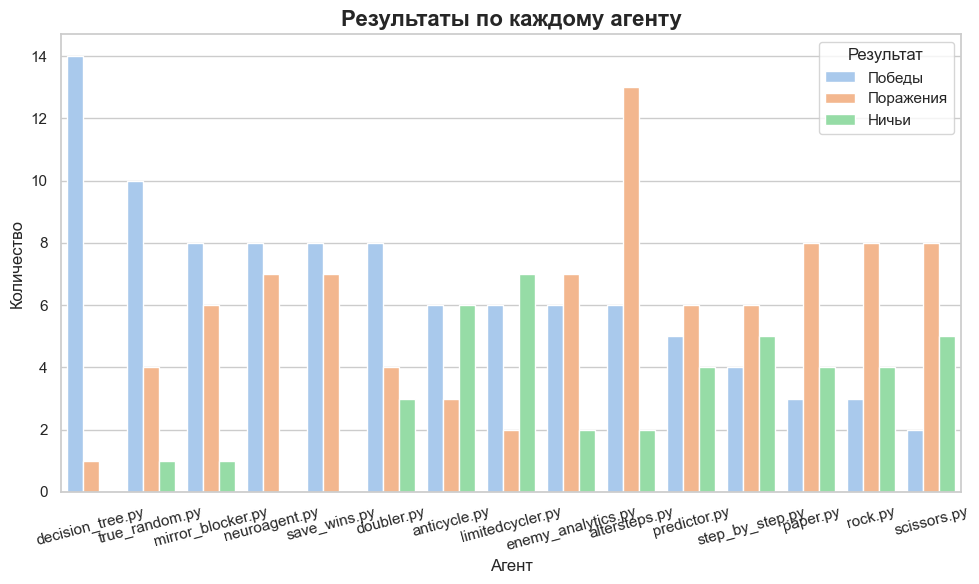

In [12]:
sns.set_theme(style="whitegrid", palette="pastel")

plt.figure(figsize=(10, 6))
df_melted = df_results.melt(id_vars="Агент", var_name="Результат", value_name="Количество")

sns.barplot(data=df_melted, x="Агент", y="Количество", hue="Результат", dodge=True, saturation=0.8)


plt.title("Результаты по каждому агенту", fontsize=16, fontweight="bold")
plt.xlabel("Агент", fontsize=12)
plt.ylabel("Количество", fontsize=12)
plt.legend(title="Результат", loc="upper right")
plt.xticks(rotation=15)
plt.tight_layout()

plt.show()

График говорит сам за себя. Абсолютный чемпион - `decision_tree`. На удивление неплохо показал себя рандом, видимо повезло) Как-то так!